# Hyperparameters and Model validation
## Thinking about model validation
The first section shows a naive approach to model validatoin and why it fails, before exploring the use of holdout set and cross-validation for more robust model evaluation.

### Model validation the wrong way

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
x = iris.data
y = iris.target

Next, we choose a model and hyperparameters. Here we'll use a *k*-nearest neighbors classifier with ```n_neighbors = 1```. This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training point":

In [19]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

model.fit(x,y)
y_model = model.predict(x)

We compute the fraction of correctly labeled points:

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

The issue is, we get a score of 1, meaning 100% model accuracy. This stems from the error of validating the model on the training set.


### Model validation the right way: Holdout Sets
A better sense of a model's performance can be found by using what's known as a *holdout set*: that is, we hold back some subset of the data from the training of the model, and the use this holdout set to check the model's perfomace. This splitting can be done using the ```train_test_split()``` utility.

In [13]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=0, train_size=0.5)

# fit the model on one set of data
model.fit(xtrain, ytrain)

# evaluate the model on the second set of data
y_model = model.predict(xtest)
accuracy_score(ytest, y_model)

0.9066666666666666

### Model Validation via Cross-Validation
One disatvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training. In the preceding case, half the dataset does not contribute to the training of the model. This is not optimal, especially if the initial set of training data is small.

One way to address this is to use *cross-validation* ; that is, to do a sequence of fits where each subset of the data is used both as training set and as a validation set.

In [14]:
# twofold cross validation
y2_model = model.fit(xtrain, ytrain).predict(xtest)
y1_model = model.fit(xtest, ytest).predict(xtrain)
accuracy_score(ytest, y2_model), accuracy_score(ytrain, y1_model)

(0.9066666666666666, 0.96)

In [15]:
# Split data into five groups and use each in turn to evaluate the model fit on the other four-fifths of the data.
from sklearn.model_selection import cross_val_score
cross_val_score(model, x, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Repeating the validation actoss different subsets of the data gives an even better idea of the performance of the algorithm.
As an extreme, one could try "leave one out" cross validation where the number of cross validations is equal to the the amout of data points.

In [22]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, x, y, cv=LeaveOneOut())
print(scores)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


Because we have 150 samples, the leave-one-out cross-validation yields scores fro 150 trials, and each score indicates either a successful or an unsuccesful prediction. Taking the mean of these gieves an estimate of the error rate:

In [23]:
scores.mean()

0.96

Other cross=validation schemes can be used similarly. For a description of what is availabe in Scikit-Learn, use IPython to explore the <sklearn.model_selection> submodule, or take a look at the docs.

## Selecting the best model
Now that we've explored the basics of validation and cross-validation, we will go into a little more depth regarding model selection and selection of hyperparameters. These issues are some of the most important aspects of the practice of machine learning, but I find that this information is often glossed over in introductory machine learning tutorials.

Of core importance is the following question: *if our estimator is underperforming, how should we move forward?* There are several possible answers:
- Use a more complicated/more flexible model
- Use a less complicated/less flexibel model.
- Gather more training samples.
- Gather more data to add features to each sample.

The answer to this question is often counterintuitive. In particular sometimes using a more complicated model will give worse results, and adding more training samples may not improve your results. The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### Validation Curves in Scikit-Learn
Let's look at an example of using cross-validatiation to compute the validation curve of a class of models. Here we will use a *polynomial regression* model, a generalized linear model in which the degree of the polynomial is a tunable parameter. For example, a degree-1 polynomial fits a straight line to the data, a degree-3 polynomial a cubic curve

We can generalize this to an number of polynomial features. In Scikit-Learn, we can implement this with a linear regression classifier combined with the polynomial pre-processor. We will use a *pipeline* to string these operations together.

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

# make some data to fit the model to
import numpy as np

def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    x = rng.rand(N, 1) **2
    y = 10 - 1. / (x.ravel() + 0.1)
    if err > 0:
        y+=err * rng.randn(N)
        return x,y

x, y = make_data(40)

We can now visualize the data, along with polynomial fits of several degrees

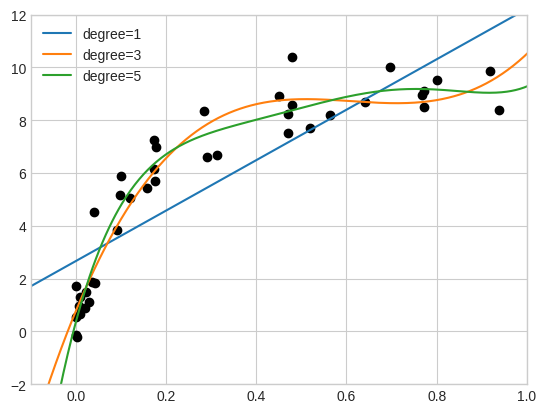

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

x_test = np.linspace(-0.1, 1.1, 500)[:,None]

plt.scatter(x.ravel(), y, color='black')
axis = plt.axis()
for degree in [1,3,5]:
    y_test=PolynomialRegression(degree).fit(x,y).predict(x_test)
    plt.plot(x_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1)
plt.ylim(-2,12)
plt.legend(loc='best');

The know controlling model complexity in this case is the degree of the polynomial, which can be any nonnegative integer. A useful question to answer is this: what degree of polynomial provides a suitable trade-off between bias (underfitting) and variance (overfitting)?
We can make progress in this by visualiying the validation curve for this particular data and model; this can be done straigth forwardly using the ```validation_curve``` convenience routing provided by sklearn. Given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and the validation score across the range.

Text(0, 0.5, 'score')

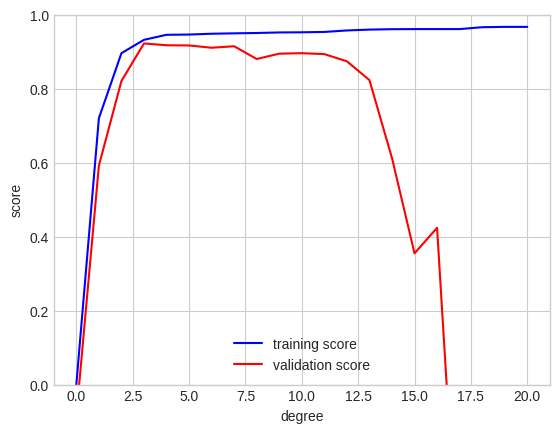

In [36]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(
    PolynomialRegression(), x, y,
    param_name='polynomialfeatures__degree',
    param_range=degree, cv=7
)

plt.plot(degree, np.median(train_score, 1),
         color='blue', label='training score')
plt.plot(degree, np.median(val_score,1),
         color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlabel('degree')
plt.ylabel('score')

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score, the training score in monotonically imporving with increased model complexity, and the validation score reaches a maximum before dropping off as the model becomes overfit.
From the validation curve we can determine that the optimal trade-off between bias and variance is found for a third-order polynomial. we can compute and display this fit over the original data as follows:

(-0.04687651021505175,
 0.9844070023112612,
 -0.7308177116555796,
 10.902869392322714)

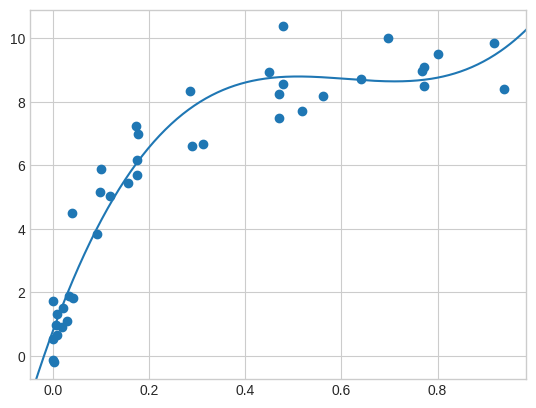

In [38]:
plt.scatter(x.ravel(),y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(x,y).predict(x_test)
plt.plot(x_test.ravel(), y_test)
plt.axis(lim)

Notice that finding this optimal model did not actually require us to compyte the training score, but exaining the relationship between the training score and validation score can give us useful insight into the performance of the model.

## Learning curves
One important aspect of model complexity is that the optimal model will generally depend on the size of your training data. For example, let's generate a new dataset with five times as may points.

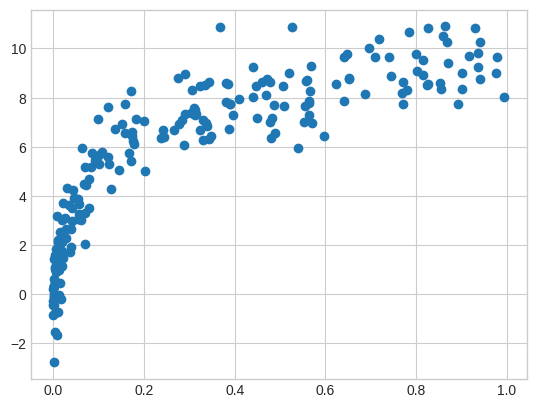

In [40]:
x2, y2 = make_data(200)
plt.scatter(x2.ravel(), y2)

Now let's duplicate the preceding code to plot the validation curve for this larger dataset; for reference, we'll overplot the previous results as well.

Text(0, 0.5, 'score')

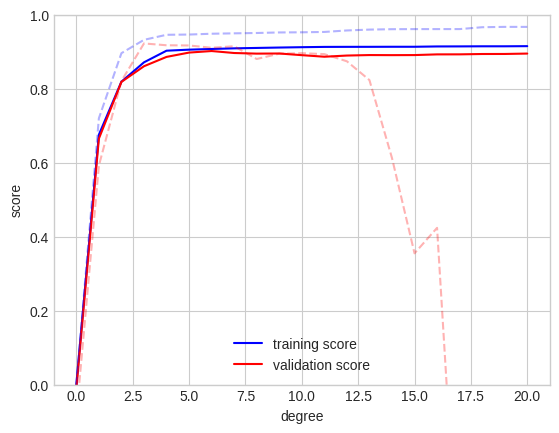

In [41]:

degree = np.arange(21)
train_score2, val_score2 = validation_curve(
    PolynomialRegression(), x2, y2,
    param_name='polynomialfeatures__degree',
    param_range=degree, cv=7
)

plt.plot(degree, np.median(train_score2, 1),
         color='blue', label='training score')
plt.plot(degree, np.median(val_score2,1),
         color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1),
         color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score,1),
         color = 'red', alpha=0.3, linestyle = 'dashed')
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlabel('degree')
plt.ylabel('score')

The solid lines show the new results, while the fainter dashed lines show the results on the previous smaller dataset. It is clear from the validation curve that the larger dataset can suppport a much more complicated model: the peak here is probably around a degree of 6 but even a degree-20 model isn't serously overfitting the data - the validation and training scores remain very close. So the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points. We can gain further insight by exploring the behavior of the model as a function of the number fo training points, which we can do by using increasingly larger subsets of the data to fit our model. A plot of the training/validation score with respect to the size of the training set is sometimes known as a *learning cureve*.

The general behavior we would expect form a learning curve is this:
- A model of a given complexity will *overfit* a ssmall dataset: this means the training score will be relatively high, while the validation score will be relatively low.
- A model of a given complexity will *underfit* a large dataset: this mean that the traingin score will decrease, but the validation score will increase.
- A model will never, except by chance, giva a better score to the validation set than the training set: this means the curves should keep getting closer together but never cross.

Once you have enough points that a particular model has converged, *adding more training data will not help you*. The only way to increase model performance in this case is to use another (often more complex) model.

Sklear offers convenient utility for computing such learning curves from your models; ere we will compute a learning curve for our original dataset with a second-ordre polynomial model and a ninth-order polynomial.

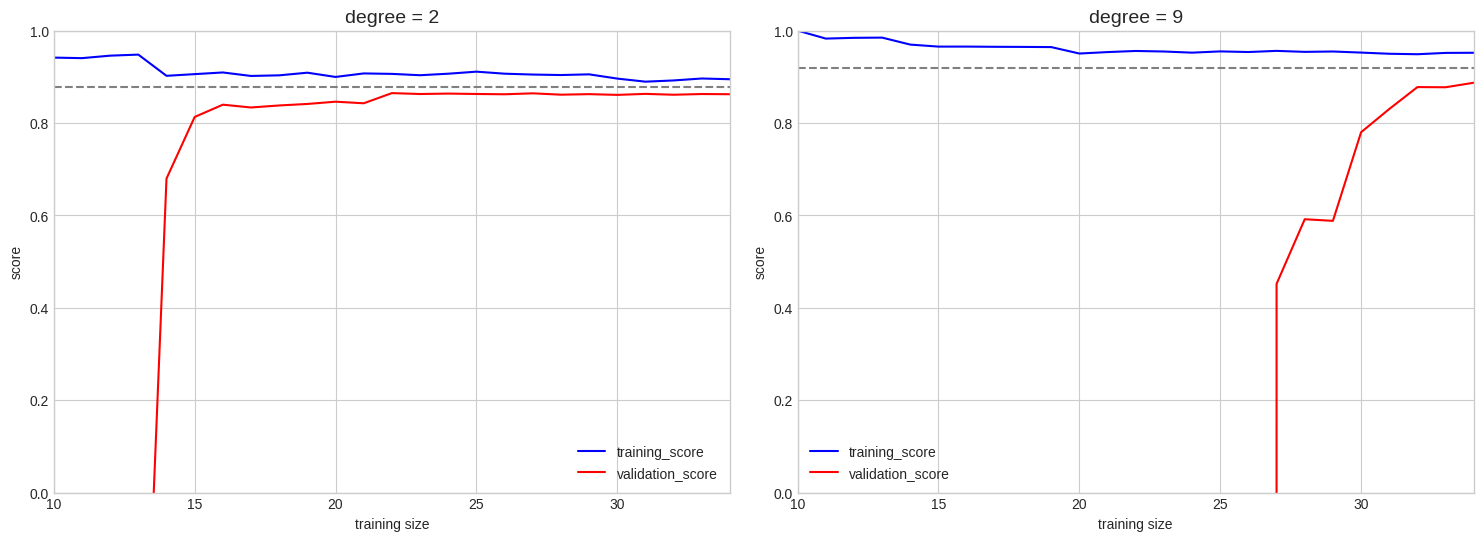

In [42]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1,2,figsize=(16,6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate ([2, 9]):
    N, train_lc, val_lc = learning_curve(
        PolynomialRegression(degree), x, y, cv=7,
        train_sizes=np.linspace(0.3,1,25)
    )
    ax[i].plot(N, np.mean(train_lc, 1),
               color='blue', label='training_score')
    ax[i].plot(N, np.mean(val_lc,1),
               color='red', label='validation_score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0],
                 N[-1], color='grey',linestyle='dashed')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

This is a valuable diagnostic, beacuase it gives us a visual depiction of how our model responds to increasing amounts of training data. In particular, when the learning curve has already converged *adding more training data will not significanlty improve the fit!* This situation is seen in the left panel, with the learning curve for the degree-2 model.

The only way to increase the converged score is to use a different (usually more complicated) model. We see this in the right panel: by moving to a much more complicated model, we increase the score of convergence (indicated by the dashed line), but at the expense of higher model variance (indicated by the difference between the training and validation scores). If we were to add even more data points, the learning curve for the more complicated model would eventually converge.

Plotting a learning curve for your particular choice of model and dataset can help you to make this type of decision about how to move forward in improving your analysis.

The solid lines show thenew results, while the fainter dashed lines show the results on the previous smaller dataset. It is clear form the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6 but even a degree-20 model isn't seriously overfitting the data -  the validation and training scores remain very close.


## Validation in Practice: Grid search
Sklearn provides a feature to find the optimal parameters for the model. This is the grid search. This will be used to find the optimal polynomial model.

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

Noice that like a normal estimator, this has not yet been applied to any data. Calling the fit method will fit hte model at each grid point, keeping track of the scores along the way.

In [44]:
grid.fit(x, y)

# Now that the model is fit, we can ask for the best parameters as follows:

grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}

(-0.04687651021505175,
 0.9844070023112612,
 -0.7308177116555796,
 10.902869392322714)

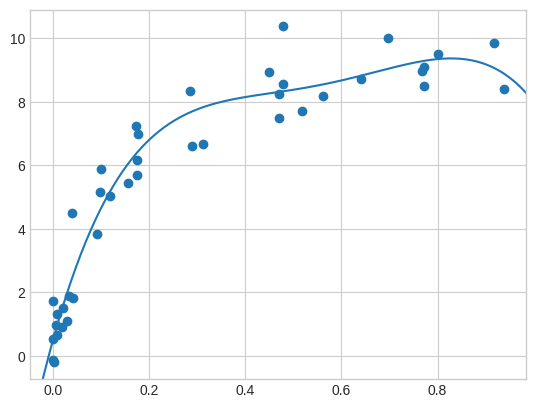

In [45]:
# Finally, if we wish, we can use the best model and show the fit to our data using code from before
model = grid.best_estimator_
plt.scatter(x.ravel(), y)
lim = plt.axis()
y_test = model.fit(x, y).predict(x_test)
plt.plot(x_test.ravel(), y_test)
plt.axis(lim)

Other options in GridsearchCV invlude the ability to specify a custom scoring function, to parallelize the computations, to do randomized searche, and more. See docs.


## Summary
this chapter explored the concept of model validation and hyperparameter optimization, focusing on intuitive aspects of the bias-variance tradoff and how it comes into play wehn fitting models to data. in particular, we found that the use of a validation set or cross-validation approach is vital when tuning parameters in order to aboid overfitting for more complex/flexible models.